In [1]:
# If you're on Google Colab, you can upload your kaggle.json file using the following code
from google.colab import files
files.upload()  # Choose kaggle.json to upload


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"tony1241","key":"5585cbdbeeb5bf8cc2b8d49b6bd8e599"}'}

In [2]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


In [3]:
!pip install kaggle


In [4]:
# Replace 'nunenuh/pytorch-challange-flower-dataset' with the correct dataset path from Kaggle
!kaggle datasets download -d nunenuh/pytorch-challange-flower-dataset


Dataset URL: https://www.kaggle.com/datasets/nunenuh/pytorch-challange-flower-dataset
License(s): CC0-1.0
100% 330M/330M [00:03<00:00, 135MB/s]
100% 330M/330M [00:03<00:00, 104MB/s]


In [5]:
import zipfile
with zipfile.ZipFile("pytorch-challange-flower-dataset.zip", 'r') as zip_ref:
    zip_ref.extractall("flower_data")


In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt


In [7]:
import zipfile
with zipfile.ZipFile("pytorch-challange-flower-dataset.zip", 'r') as zip_ref:
    zip_ref.extractall("flower_data")


In [8]:
# Data transformations for training and validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

# Load data
data_dir = 'flower_data'
image_datasets = {x: datasets.ImageFolder(root=f'{data_dir}/{x}', transform=data_transforms[x]) for x in ['train', 'val']}
dataloaders = {x: DataLoader(image_datasets[x], batch_size=32, shuffle=True) for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes


In [9]:
# Load a pretrained ResNet model
model = models.resnet18(pretrained=True)
# Replace the final layer
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, len(class_names))
model = model.to('cuda' if torch.cuda.is_available() else 'cpu')


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 109MB/s]


In [10]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)


In [14]:
# Validation accuracy
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for inputs, labels in dataloaders['val']:
        inputs = inputs.to('cuda' if torch.cuda.is_available() else 'cpu')
        labels = labels.to('cuda' if torch.cuda.is_available() else 'cpu')
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = correct / total
print(f'Validation Accuracy: {accuracy * 100:.2f}%')


Validation Accuracy: 96.45%


In [16]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    best_model_wts = model.state_dict()
    best_acc = 0.0
    train_acc = []
    val_acc = []
    train_loss = []
    val_loss = []

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to('cuda' if torch.cuda.is_available() else 'cpu')
                labels = labels.to('cuda' if torch.cuda.is_available() else 'cpu')

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            if phase == 'train':
                scheduler.step()
                train_loss.append(epoch_loss)
                train_acc.append(epoch_acc.item())
            else:
                val_loss.append(epoch_loss)
                val_acc.append(epoch_acc.item())

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = model.state_dict()

    model.load_state_dict(best_model_wts)
    return model, train_loss, val_loss, train_acc, val_acc


In [17]:
model, train_loss, val_loss, train_acc, val_acc = train_model(model, criterion, optimizer, scheduler, num_epochs=25)


Epoch 0/24
----------
train Loss: 0.3416 Acc: 0.9367
val Loss: 0.1789 Acc: 0.9633
Epoch 1/24
----------
train Loss: 0.3365 Acc: 0.9400
val Loss: 0.1827 Acc: 0.9707
Epoch 2/24
----------
train Loss: 0.3428 Acc: 0.9362
val Loss: 0.1789 Acc: 0.9707
Epoch 3/24
----------
train Loss: 0.3467 Acc: 0.9382
val Loss: 0.1795 Acc: 0.9682
Epoch 4/24
----------
train Loss: 0.3428 Acc: 0.9365
val Loss: 0.1818 Acc: 0.9694
Epoch 5/24
----------
train Loss: 0.3629 Acc: 0.9347
val Loss: 0.1799 Acc: 0.9682
Epoch 6/24
----------
train Loss: 0.3536 Acc: 0.9362
val Loss: 0.1779 Acc: 0.9719
Epoch 7/24
----------
train Loss: 0.3496 Acc: 0.9368
val Loss: 0.1775 Acc: 0.9670
Epoch 8/24
----------
train Loss: 0.3598 Acc: 0.9338
val Loss: 0.1812 Acc: 0.9731
Epoch 9/24
----------
train Loss: 0.3445 Acc: 0.9359
val Loss: 0.1823 Acc: 0.9719
Epoch 10/24
----------
train Loss: 0.3538 Acc: 0.9353
val Loss: 0.1833 Acc: 0.9719
Epoch 11/24
----------
train Loss: 0.3368 Acc: 0.9405
val Loss: 0.1807 Acc: 0.9707
Epoch 12/24
--

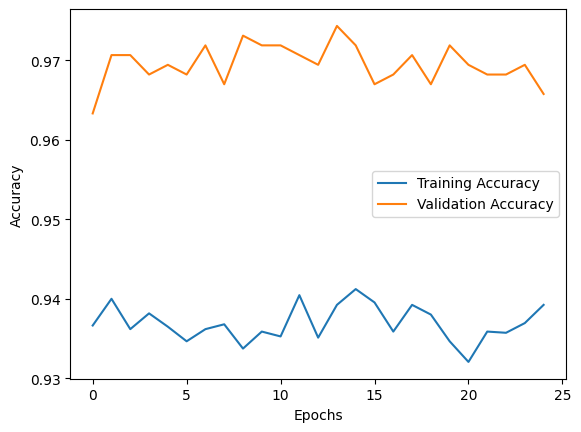

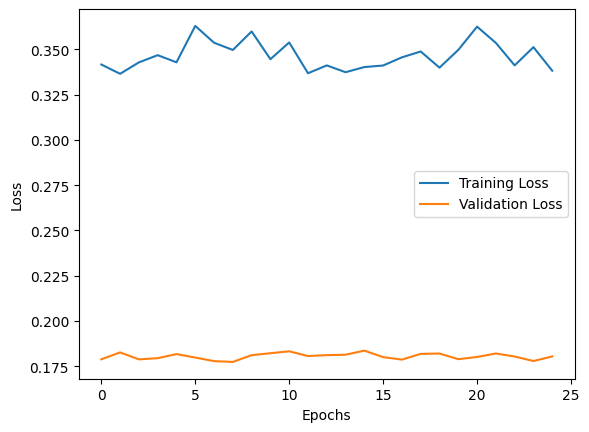

In [18]:
# Plot accuracy
plt.plot(train_acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot loss
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [21]:
# Validation accuracy
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for inputs, labels in dataloaders['val']:
        inputs = inputs.to('cuda' if torch.cuda.is_available() else 'cpu')
        labels = labels.to('cuda' if torch.cuda.is_available() else 'cpu')
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = correct / total
print(f'Validation Accuracy: {accuracy * 100:.2f}%')

Validation Accuracy: 97.31%


In [25]:
print(f"  Training   - Loss: {train_loss[epoch]:.4f}, Accuracy: {train_acc[epoch]:.4f}")
print(f"  Validation - Loss: {val_loss[epoch]:.4f}, Accuracy: {val_acc[epoch]:.4f}")


  Training   - Loss: 0.3382, Accuracy: 0.9393
  Validation - Loss: 0.1805, Accuracy: 0.9658


In [26]:
import pandas as pd


# Create a DataFrame with epoch-wise results
results_df = pd.DataFrame({
    'Epoch': range(1, len(train_loss) + 1),
    'Training Loss': train_loss,
    'Validation Loss': val_loss,
    'Training Accuracy': train_acc,
    'Validation Accuracy': val_acc
})

# Save DataFrame to CSV
results_df.to_csv('training_results.csv', index=False)

print("Training results saved to training_results.csv")


Training results saved to training_results.csv


In [27]:
!pip install scikit-learn


In [28]:
from sklearn.metrics import precision_score, recall_score, f1_score

def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    best_model_wts = model.state_dict()
    best_acc = 0.0
    train_loss, val_loss = [], []
    train_acc, val_acc = [], []
    train_precision, train_recall, train_f1 = [], [], []
    val_precision, val_recall, val_f1 = [], [], []

    for epoch in range(num_epochs):
        print(f'\nEpoch {epoch + 1}/{num_epochs}')
        print('-' * 30)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0
            all_labels = []
            all_preds = []

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to('cuda' if torch.cuda.is_available() else 'cpu')
                labels = labels.to('cuda' if torch.cuda.is_available() else 'cpu')

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                all_labels.extend(labels.cpu().numpy())
                all_preds.extend(preds.cpu().numpy())

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            if phase == 'train':
                scheduler.step()
                train_loss.append(epoch_loss)
                train_acc.append(epoch_acc.item())
            else:
                val_loss.append(epoch_loss)
                val_acc.append(epoch_acc.item())

            # Calculate precision, recall, and F1-score
            precision = precision_score(all_labels, all_preds, average='macro')
            recall = recall_score(all_labels, all_preds, average='macro')
            f1 = f1_score(all_labels, all_preds, average='macro')

            if phase == 'train':
                train_precision.append(precision)
                train_recall.append(recall)
                train_f1.append(f1)
            else:
                val_precision.append(precision)
                val_recall.append(recall)
                val_f1.append(f1)

            print(f'{phase.capitalize()} - Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.4f}, '
                  f'Precision: {precision:.4f}, Recall: {recall:.4f}, F1-score: {f1:.4f}')

            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = model.state_dict()

    model.load_state_dict(best_model_wts)
    return model, train_loss, val_loss, train_acc, val_acc, train_precision, train_recall, train_f1, val_precision, val_recall, val_f1


In [30]:
model, train_loss, val_loss, train_acc, val_acc, train_precision, train_recall, train_f1, val_precision, val_recall, val_f1 = train_model(model, criterion, optimizer, scheduler, num_epochs=25)



Epoch 1/25
------------------------------
Train - Loss: 0.3463, Accuracy: 0.9379, Precision: 0.9389, Recall: 0.9287, F1-score: 0.9329
Val - Loss: 0.1806, Accuracy: 0.9707, Precision: 0.9615, Recall: 0.9661, F1-score: 0.9588

Epoch 2/25
------------------------------
Train - Loss: 0.3557, Accuracy: 0.9357, Precision: 0.9356, Recall: 0.9263, F1-score: 0.9299
Val - Loss: 0.1812, Accuracy: 0.9707, Precision: 0.9557, Recall: 0.9683, F1-score: 0.9571

Epoch 3/25
------------------------------
Train - Loss: 0.3421, Accuracy: 0.9389, Precision: 0.9406, Recall: 0.9301, F1-score: 0.9341
Val - Loss: 0.1810, Accuracy: 0.9694, Precision: 0.9560, Recall: 0.9642, F1-score: 0.9535

Epoch 4/25
------------------------------
Train - Loss: 0.3400, Accuracy: 0.9356, Precision: 0.9378, Recall: 0.9272, F1-score: 0.9315
Val - Loss: 0.1796, Accuracy: 0.9719, Precision: 0.9620, Recall: 0.9705, F1-score: 0.9606

Epoch 5/25
------------------------------
Train - Loss: 0.3460, Accuracy: 0.9389, Precision: 0.9397

In [32]:
results_df = pd.DataFrame({
    'Epoch': range(1, len(train_loss) + 1),
    'Training Loss': train_loss,
    'Validation Loss': val_loss,
    'Training Accuracy': train_acc,
    'Validation Accuracy': val_acc,
    'Training Precision': train_precision,
    'Training Recall': train_recall,
    'Training F1-score': train_f1,
    'Validation Precision': val_precision,
    'Validation Recall': val_recall,
    'Validation F1-score': val_f1
})

# Save DataFrame to CSV
results_df.to_csv('training_results_with_metrics.csv', index=False)
print("Training results with precision, recall, and F1-score saved to training_results_with_metrics.csv")


Training results with precision, recall, and F1-score saved to training_results_with_metrics.csv


In [40]:
print(f"  Training   - Loss: {train_loss[epoch]:.4f}, Accuracy: {train_acc[epoch]:.4f}")
print(f"  Validation - Loss: {val_loss[epoch]:.4f}, Accuracy: {val_acc[epoch]:.4f}")
print(f"  Training Precision: {val_loss[epoch]:.4f}, Accuracy: {train_precision[epoch]:.4f}")
print(f"  Training Recall: {val_loss[epoch]:.4f}, Accuracy: {train_recall[epoch]:.4f}")
print(f"  Validation Precision: {val_loss[epoch]:.4f}, Accuracy: {val_precision[epoch]:.4f}")
print(f"  Validation Recall: {val_loss[epoch]:.4f}, Accuracy: {val_recall[epoch]:.4f}")
print(f"  Training F1-score: {val_loss[epoch]:.4f}, Accuracy: {train_f1[epoch]:.4f}")
print(f"  Validation F1-score: {val_loss[epoch]:.4f}, Accuracy: {val_f1[epoch]:.4f}")

  Training   - Loss: 0.3427, Accuracy: 0.9379
  Validation - Loss: 0.1791, Accuracy: 0.9694
  Training Precision: 0.1791, Accuracy: 0.9381
  Training Recall: 0.1791, Accuracy: 0.9318
  Validation Precision: 0.1791, Accuracy: 0.9587
  Validation Recall: 0.1791, Accuracy: 0.9628
  Training F1-score: 0.1791, Accuracy: 0.9340
  Validation F1-score: 0.1791, Accuracy: 0.9538
